In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_v2_dft_iq_HIGH_SNR'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

HIGH_SNR_LOWER_BOUND = 10 # dB

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


## Filter dataset for training with HIGH SNR only: at least 10 dB SNR

In [11]:
training_dataset_df = dataset_df[dataset_df[snr_column_dataframe_name] >= HIGH_SNR_LOWER_BOUND]
training_dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
5000,"[[0.0010849662, 0.0079283025, -0.002837673, 0....","[[0.021192234718910186, 0.09395798107837913, 0...",AM-SSB,12
5001,"[[-0.0037544249, 0.0034207758, -0.0040703234, ...","[[0.0037139705855224747, -0.1130547299101726, ...",AM-SSB,12
5002,"[[0.0019210369, -0.010300477, -0.00801645, 0.0...","[[-0.11531920377456117, 0.06953918660995068, 0...",AM-SSB,12
5003,"[[0.0009419464, -0.0010139677, 0.0034730528, -...","[[-0.015283932283637114, 0.01093289374031553, ...",AM-SSB,12
5004,"[[-0.00891647, 0.0006878033, -0.002268499, 0.0...","[[0.0021729132931795903, 0.05911010226909384, ...",AM-SSB,12
...,...,...,...,...
214995,"[[0.00041843185, 0.0006587509, 0.00080177194, ...","[[0.11188671516720206, -0.001483236477754289, ...",AM-DSB,12
214996,"[[0.0013838852, 0.0012232062, 0.0010781031, 0....","[[0.14492166912532412, 0.003731511383079607, 0...",AM-DSB,12
214997,"[[0.0014226807, 0.0016607252, 0.0015581344, 0....","[[0.17922684608493, 0.0029565886377778752, 0.0...",AM-DSB,12
214998,"[[0.0011526298, 0.0015653906, 0.0014872396, 0....","[[0.19208512833574787, -0.004767836118948571, ...",AM-DSB,12


# Neural network

## Configuration

In [12]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [13]:
signals = []

for i in range(0, len(dataset_df.index)):
    signal = []
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][1])
    signal.append(dataset_df[dft_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[dft_signals_column_dataframe_name][i][1])
    signals.append(signal)

labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [14]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

training_datapoints = len(training_dataset_df.index)

# take a portion of the dataset as training set
n_train = int(training_datapoints * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(training_dataset_df.index.values.tolist(), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [15]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [16]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(38500, 4, 128)
[4, 128]


In [17]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 4, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 8, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 3, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 3, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 7, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 3, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 3, 80)          0

### Train the model

In [18]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


 1/38 [..............................] - ETA: 7:14 - loss: 2.3980

 6/38 [===>..........................] - ETA: 0s - loss: 2.3977  

12/38 [========>.....................] - ETA: 0s - loss: 2.3971

18/38 [=============>................] - ETA: 0s - loss: 2.3960

25/38 [==================>...........] - ETA: 0s - loss: 2.3934

32/38 [========================>.....] - ETA: 0s - loss: 2.3880



38/38 [==============================] - ETA: 0s - loss: 2.3810

38/38 [==============================] - 13s 41ms/step - loss: 2.3798 - val_loss: 2.3252


Epoch 2/100
 1/38 [..............................] - ETA: 0s - loss: 2.1832

 7/38 [====>.........................] - ETA: 0s - loss: 2.1715

13/38 [=========>....................] - ETA: 0s - loss: 2.1659

20/38 [==============>...............] - ETA: 0s - loss: 2.1610

26/38 [===================>..........] - ETA: 0s - loss: 2.1569

33/38 [=========================>....] - ETA: 0s - loss: 2.1531

38/38 [==============================] - 1s 26ms/step - loss: 2.1502 - val_loss: 2.2864


Epoch 3/100
 1/38 [..............................] - ETA: 0s - loss: 2.0870

 8/38 [=====>........................] - ETA: 0s - loss: 2.0983

14/38 [==========>...................] - ETA: 0s - loss: 2.1019

20/38 [==============>...............] - ETA: 0s - loss: 2.1022

27/38 [====================>.........] - ETA: 0s - loss: 2.1018

34/38 [=========================>....] - ETA: 0s - loss: 2.1017

38/38 [==============================] - 1s 24ms/step - loss: 2.1016 - val_loss: 2.2781


Epoch 4/100
 1/38 [..............................] - ETA: 0s - loss: 2.0881

 7/38 [====>.........................] - ETA: 0s - loss: 2.0929

14/38 [==========>...................] - ETA: 0s - loss: 2.0908

21/38 [===============>..............] - ETA: 0s - loss: 2.0879

28/38 [=====================>........] - ETA: 0s - loss: 2.0851

35/38 [==========================>...] - ETA: 0s - loss: 2.0824

38/38 [==============================] - 1s 23ms/step - loss: 2.0806 - val_loss: 2.2560


Epoch 5/100
 1/38 [..............................] - ETA: 0s - loss: 1.9852

 8/38 [=====>........................] - ETA: 0s - loss: 2.0060

15/38 [==========>...................] - ETA: 0s - loss: 2.0050

22/38 [================>.............] - ETA: 0s - loss: 2.0002

29/38 [=====================>........] - ETA: 0s - loss: 1.9946

36/38 [===========================>..] - ETA: 0s - loss: 1.9891

38/38 [==============================] - 1s 23ms/step - loss: 1.9865 - val_loss: 2.1577


Epoch 6/100
 1/38 [..............................] - ETA: 0s - loss: 1.8837

 8/38 [=====>........................] - ETA: 0s - loss: 1.8620

15/38 [==========>...................] - ETA: 0s - loss: 1.8540



22/38 [================>.............] - ETA: 0s - loss: 1.8461

29/38 [=====================>........] - ETA: 0s - loss: 1.8382

36/38 [===========================>..] - ETA: 0s - loss: 1.8310

38/38 [==============================] - 1s 23ms/step - loss: 1.8281 - val_loss: 2.1274


Epoch 7/100
 1/38 [..............................] - ETA: 0s - loss: 1.7007

 8/38 [=====>........................] - ETA: 0s - loss: 1.7182



15/38 [==========>...................] - ETA: 0s - loss: 1.7180

21/38 [===============>..............] - ETA: 0s - loss: 1.7172

27/38 [====================>.........] - ETA: 0s - loss: 1.7152

34/38 [=========================>....] - ETA: 0s - loss: 1.7123

38/38 [==============================] - 1s 24ms/step - loss: 1.7102 - val_loss: 2.1868


Epoch 8/100
 1/38 [..............................] - ETA: 0s - loss: 1.6736

 8/38 [=====>........................] - ETA: 0s - loss: 1.6513

15/38 [==========>...................] - ETA: 0s - loss: 1.6453

22/38 [================>.............] - ETA: 0s - loss: 1.6406

29/38 [=====================>........] - ETA: 0s - loss: 1.6381

36/38 [===========================>..] - ETA: 0s - loss: 1.6361

38/38 [==============================] - 1s 23ms/step - loss: 1.6353 - val_loss: 2.2501


Epoch 9/100
 1/38 [..............................] - ETA: 0s - loss: 1.6033

 8/38 [=====>........................] - ETA: 0s - loss: 1.5925

15/38 [==========>...................] - ETA: 0s - loss: 1.5853

21/38 [===============>..............] - ETA: 0s - loss: 1.5817

28/38 [=====================>........] - ETA: 0s - loss: 1.5792

35/38 [==========================>...] - ETA: 0s - loss: 1.5774

38/38 [==============================] - 1s 23ms/step - loss: 1.5765 - val_loss: 2.3048


Epoch 10/100
 1/38 [..............................] - ETA: 0s - loss: 1.5331

 8/38 [=====>........................] - ETA: 0s - loss: 1.5390

15/38 [==========>...................] - ETA: 0s - loss: 1.5340

22/38 [================>.............] - ETA: 0s - loss: 1.5298

29/38 [=====================>........] - ETA: 0s - loss: 1.5263

36/38 [===========================>..] - ETA: 0s - loss: 1.5236

38/38 [==============================] - 1s 23ms/step - loss: 1.5225 - val_loss: 2.3917


Epoch 11/100
 1/38 [..............................] - ETA: 0s - loss: 1.4967

 8/38 [=====>........................] - ETA: 0s - loss: 1.4814

15/38 [==========>...................] - ETA: 0s - loss: 1.4813

22/38 [================>.............] - ETA: 0s - loss: 1.4807

29/38 [=====================>........] - ETA: 0s - loss: 1.4798



36/38 [===========================>..] - ETA: 0s - loss: 1.4783

38/38 [==============================] - 1s 23ms/step - loss: 1.4775 - val_loss: 2.4717


# Evaluate and Plot Model Performance

In [19]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

  1/178 [..............................] - ETA: 3s - loss: 1.9183

 16/178 [=>............................] - ETA: 0s - loss: 2.0770

 32/178 [====>.........................] - ETA: 0s - loss: 2.0872

 47/178 [======>.......................] - ETA: 0s - loss: 2.0444

 64/178 [=========>....................] - ETA: 0s - loss: 2.0698

 80/178 [============>.................] - ETA: 0s - loss: 2.1143

 97/178 [===============>..............] - ETA: 0s - loss: 2.1533

113/178 [==================>...........] - ETA: 0s - loss: 2.1473

129/178 [====================>.........] - ETA: 0s - loss: 2.1175

146/178 [=======================>......] - ETA: 0s - loss: 2.1371

163/178 [==========================>...] - ETA: 0s - loss: 2.1290

178/178 [==============================] - 1s 3ms/step - loss: 2.1274


2.1274425983428955


## Loss

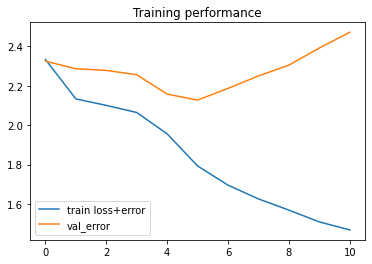

In [20]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

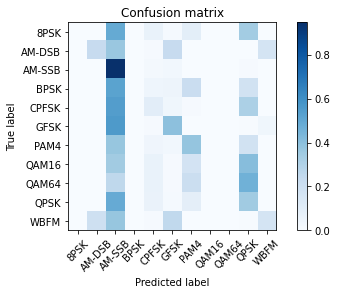

In [22]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09036363636363637


Overall Accuracy:  0.09190909090909091


Overall Accuracy:  0.09036363636363637


Overall Accuracy:  0.09081818181818181


Overall Accuracy:  0.09018181818181818


Overall Accuracy:  0.09827272727272728


Overall Accuracy:  0.11472727272727273


Overall Accuracy:  0.16945454545454544


Overall Accuracy:  0.26854545454545453


Overall Accuracy:  0.34436363636363637


Overall Accuracy:  0.3519090909090909


Overall Accuracy:  0.3610909090909091


Overall Accuracy:  0.37772727272727274


Overall Accuracy:  0.369


Overall Accuracy:  0.36827272727272725


Overall Accuracy:  0.38130563798219586


Overall Accuracy:  0.3688902551490931


Overall Accuracy:  0.3733413751507841


Overall Accuracy:  0.36396724294813465


Overall Accuracy:  0.38112745098039214


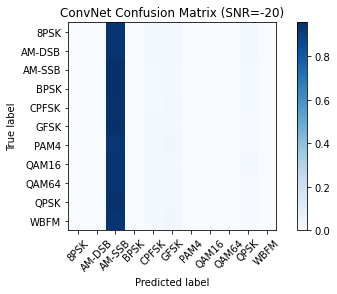

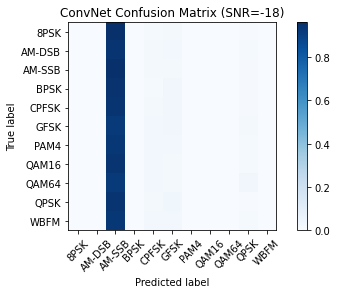

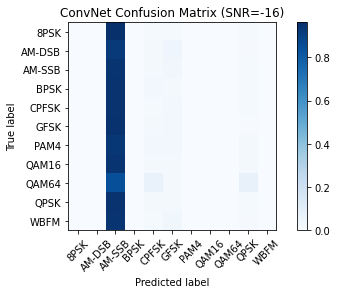

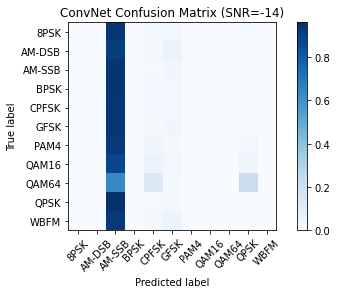

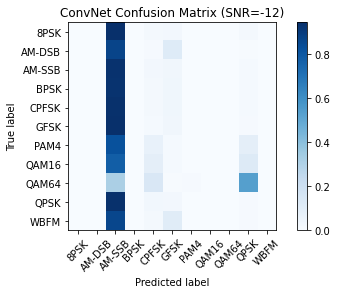

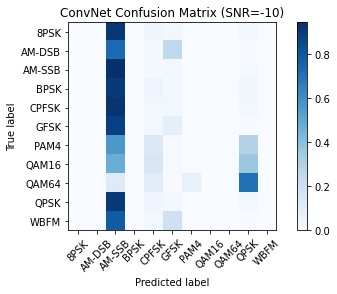

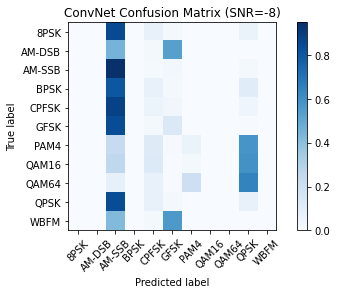

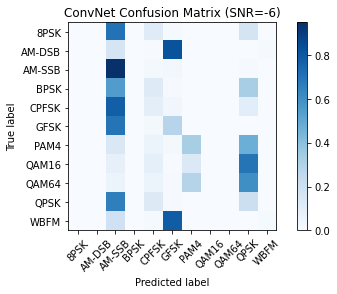

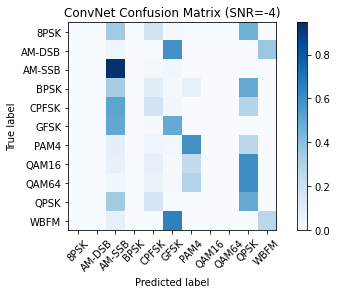

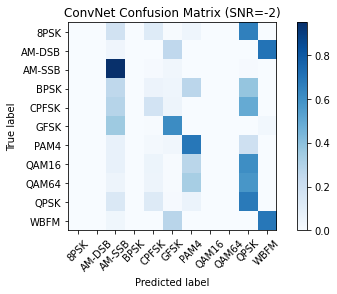

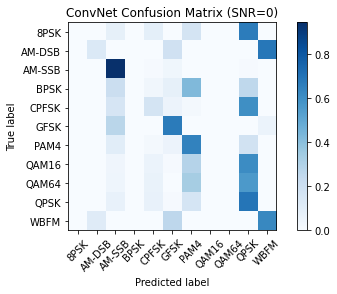

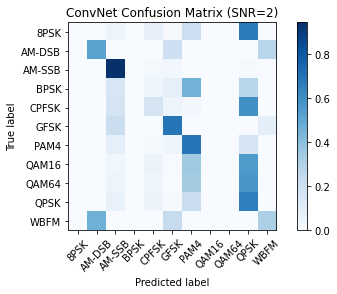

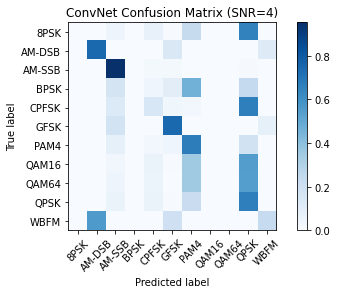

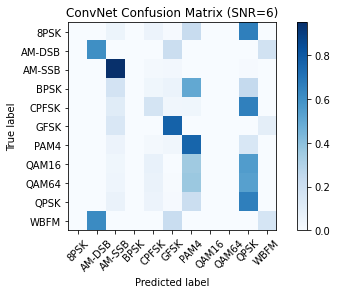

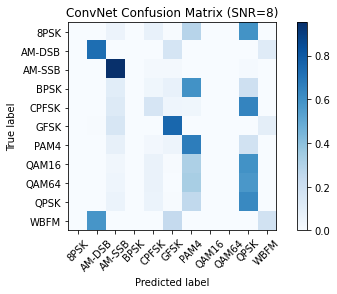

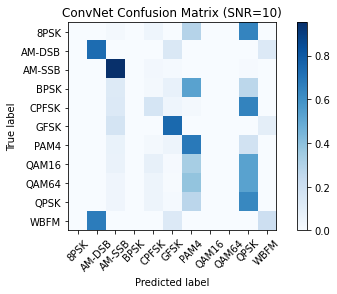

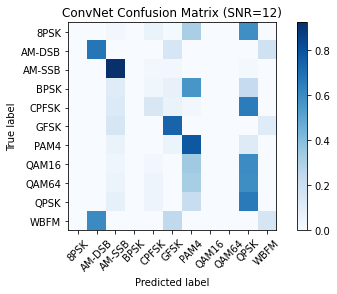

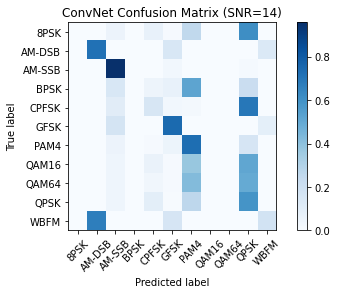

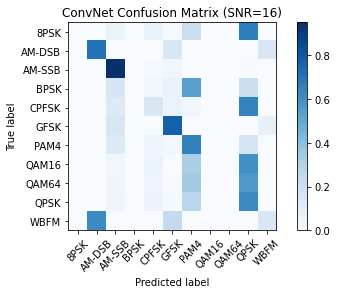

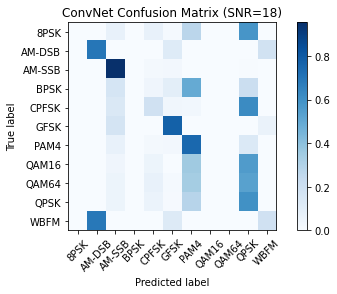

In [23]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [24]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,9,9,9,11,16,26,34,35,36,37,36,36,38,36,37,36,38


In [25]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

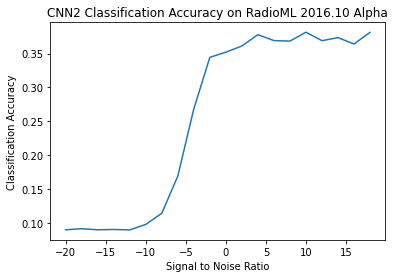

In [26]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")